In [1]:
import json
import os
import pandas as pd
import isodate
import requests
import numpy as np
import cv2
from collections import Counter
from sklearn.cluster import KMeans
import time
from tqdm import tqdm
import random
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import ast
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
df=pd.read_csv("model_datas.csv", encoding="utf-8-sig")
df=df.drop(columns=['Unnamed: 0','Unnamed: 0.1','target'])
df

view_count  duration  subscriber_count  brightness   contrast  \
0       244420.0     459.0          412000.0  109.295617  50.267187   
1        11267.0    1117.0           46500.0  109.632415  78.918197   
2        12158.0    1306.0           15700.0   93.686517  89.278624   
3        14333.0    1772.0           71700.0  139.081451  66.674994   
4        58409.0    1097.0          296000.0  137.706521  74.693199   
...          ...       ...               ...         ...        ...   
7303     59924.0     890.0           45200.0  169.503289  74.661909   
7304    348120.0    2072.0          682000.0  104.467790  70.103093   
7305    857932.0     584.0          552000.0  106.026044  67.129156   
7306   2799502.0    1351.0          552000.0  127.653263  62.304253   
7307    176203.0    1275.0            4880.0   66.886318  38.438328   

      title_length  word_count  emoji_count  special_char_count  is_clickbait  \
0               17           9            0                   0             0   
1               98          37            3                   9             0   
2               22          12            0                   1             0   
3               99          50            1                   4             0   
4               55          32            3                   5             1   
...            ...         ...          ...                 ...           ...   
7303            56          21            4                   5             0   
7304            47          20            0                   5             0   
7305            43           9            0                   2             0   
7306            23           9            0                   0             0   
7307            32          15            2                   2             0   

      ...  person_small  person_medium  person_large  text_left  text_middle  \
0     ...             0              1             1          0            0   
1     ...             0              1             1          0            1   
2     ...             3              5             5          0            0   
3     ...             0              1             1          0            3   
4     ...             0              1             1          3            3   
...   ...           ...            ...           ...        ...          ...   
7303  ...             0              1             1          1            3   
7304  ...             0              2             2          0            0   
7305  ...             0              1             1          0            0   
7306  ...             0              1             1          0            1   
7307  ...             0              1             1          0            0   

      text_right  text_small  text_medium  text_large  cluster  
0              0           0            0           0        4  
1              1           0            2           1        4  
2              0           0            0           0        6  
3              1           2            3           3        0  
4              2           0            5           4        4  
...          ...         ...          ...         ...      ...  
7303           0           1            3           3        9  
7304           0           0            0           0        7  
7305           0           0            0           0        6  
7306           0           0            1           1        6  
7307           0           0            0           0        4  

[7308 rows x 40 columns]

In [25]:
df_cluster=pd.read_csv("updated_cluster.csv", encoding="utf-8-sig")
df_cluster=df_cluster.iloc[:,-1]
df['cluster']=df_cluster

In [9]:
df['log_view_count'] = np.log1p(df['view_count'])

In [11]:
from sklearn.preprocessing import StandardScaler
numeric_cols = ['duration', 'subscriber_count', 'brightness', 'contrast']
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [13]:
df['has_question_mark'] = df['has_question_mark'].astype(int)
df['has_exclamation'] = df['has_exclamation'].astype(int)

In [15]:
X = df.drop(columns=['view_count', 'log_view_count'])
y = df['log_view_count']

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [34]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R-squared: {r2:.4f}")

RMSE: 1.55
R-squared: 0.4226


## 클러스터링

In [189]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import numpy as np

# 데이터 로드
title_df = pd.read_csv("final_video_data.csv", encoding="utf-8-sig")
title_df

Unnamed: 0                                            title_x  \
0              0                                  결국 긴팔문신 제거 하는 조두팔   
1              1  [vlog] 고등학교 교사 직장인 브이로그 | 학부모 총회 그리고 상담 가득한 한 ...   
2              2                             오사카&교토 브이로그 • 쇼핑에미띤여자들   
3              3  마라로제엽떡+닭꼬치 꿀조합•노티드 딸기전메뉴🍓먹고 결국 컵라면2개로 마무리•옛날통닭...   
4              4  [썰레디윗미] 이젠 말할 수 있다🙄 역대급 똥차 썰 낋여오니라.ㅣ이게 실화라고? 구...   
...          ...                                                ...   
7303        7303  (광고❌) 지금 바로 적용되는 저렴한 호텔 예약 꿀팁 🧑🏻‍💻 이건 몰랐을걸..절대...   
7304        7304    12월에 또 갈 결심(온천호텔, 탄금호 캠핑장, 커피 주는 박물관, 한복 셀프사진관)   
7305        7305        일본 캡슐호텔에서 50시간 살아보기 | 일본#2   
7306        7306                            세계에서 가장 작은 나라의 가장 작은 호텔   
7307        7307                   해즈빈 호텔 인물 탐구 | 만능 싸이코 사슴 -📻알래스터📻   

         video_id published_date  \
0     t-zwVkTOZA8     2025-03-28   
1     AMwSEsFVRGg     2025-03-28   
2     PocqBywf0FU     2025-02-24   
3     6eNhJ4LYr1k     2025-03-29   
4     G9tXGudpOCo     2025-03-28   
...           ...            ...   
7303  GPWGgXXT1Aw     2025-01-31   
7304  Q5uzsA3_oTE     2024-11-29   
7305  ZDUE_TI-od8     2024-07-01   
7306  ubnBh-HRcrc     2023-12-25   
7307  WTDMvhnKo9I     2024-07-06   

                                          thumbnail_url  view_count  \
0     https://i.ytimg.com/vi/t-zwVkTOZA8/maxresdefau...    244420.0   
1     https://i.ytimg.com/vi/AMwSEsFVRGg/maxresdefau...     11267.0   
2     https://i.ytimg.com/vi/PocqBywf0FU/maxresdefau...     12158.0   
3     https://i.ytimg.com/vi/6eNhJ4LYr1k/maxresdefau...     14333.0   
4     https://i.ytimg.com/vi/G9tXGudpOCo/maxresdefau...     58409.0   
...                                                 ...         ...   
7303  https://i.ytimg.com/vi/GPWGgXXT1Aw/maxresdefau...     59924.0   
7304  https://i.ytimg.com/vi/Q5uzsA3_oTE/maxresdefau...    348120.0   
7305  https://i.ytimg.com/vi/ZDUE_TI-od8/maxresdefau...    857932.0   
7306  https://i.ytimg.com/vi/ubnBh-HRcrc/maxresdefau...   2799502.0   
7307  https://i.ytimg.com/vi/WTDMvhnKo9I/maxresdefau...    176203.0   

      like_count  comment_count  duration  \
0            NaN          221.0     459.0   
1          265.0           54.0    1117.0   
2          315.0          110.0    1306.0   
3          441.0           71.0    1772.0   
4            NaN          118.0    1097.0   
...          ...            ...       ...   
7303      1928.0           64.0     890.0   
7304     11536.0         1000.0    2072.0   
7305      8408.0          676.0     584.0   
7306     25017.0         1200.0    1351.0   
7307      2659.0          143.0    1275.0   

                                  channel_id  ...  emoji_count  has_emoji  \
0                         ('조두팔', '@조두팔이라고')  ...            0          0   
1            ('HappyHojin', '@Happppyhojin')  ...            3          1   
2                      ('권예왕왕', '@ye_one_e')  ...            0          0   
3                 ('째링', '@buttermellowday')  ...            1          1   
4                   ('냔지 nyanji', '@quya_a')  ...            3          1   
...                                      ...  ...          ...        ...   
7303          ('시월필름 October-film', '@시월필름')  ...            4          1   
7304  ('[하말넘많] heavytalker', '@heavytalker')  ...            0          0   
7305                     ('서재로36', '@서재로36')  ...            0          0   
7306                     ('서재로36', '@서재로36')  ...            0          0   
7307                  ('미스터 폴보', '@MrFolvo')  ...            2          1   

      special_char_count is_clickbait has_question_mark has_exclamation  \
0                      0            0             False           False   
1                      9            0             False           False   
2                      1            0             False           False   
3                      4            0             False           False   
4                      5  

In [81]:
model = SentenceTransformer("jhgan/ko-sbert-sts")  # HuggingFace 모델
title_embeddings = model.encode(title_df['title_x'].tolist(), show_progress_bar=True)

# 메타데이터 선택 및 정규화
meta_features = ['duration','title_length', 'word_count']
X_meta = title_df[meta_features].fillna(0)
X_meta_scaled = StandardScaler().fit_transform(X_meta)

X_combined = np.hstack([X_meta_scaled, title_embeddings])

Batches:   0%|          | 0/229 [00:00<?, ?it/s]

In [12]:
embedding_df = pd.DataFrame({
    'video_id': title_df['video_id'],
    'title': title_df['title_x'],
    'embedding': list(title_embeddings)
})

embedding_df.to_csv("title_embeddings.csv", index=False)

In [64]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np

def find_optimal_k(feature_matrix, k_range=range(2, 11), random_state=42):
    wcss = []
    silhouette_scores = []
    db_scores = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        labels = kmeans.fit_predict(feature_matrix)

        wcss.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(feature_matrix, labels))
        db_scores.append(davies_bouldin_score(feature_matrix, labels))

    # 📊 시각화
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    ax[0].plot(k_range, wcss, marker='o')
    ax[0].set_title('Elbow Method (WCSS)')
    ax[0].set_xlabel('Number of Clusters (k)')
    ax[0].set_ylabel('WCSS')

    ax[1].plot(k_range, silhouette_scores, marker='o', color='green')
    ax[1].set_title('Silhouette Score')
    ax[1].set_xlabel('Number of Clusters (k)')
    ax[1].set_ylabel('Score')

    ax[2].plot(k_range, db_scores, marker='o', color='red')
    ax[2].set_title('Davies-Bouldin Index')
    ax[2].set_xlabel('Number of Clusters (k)')
    ax[2].set_ylabel('Index (Lower is better)')

    plt.tight_layout()
    plt.show()

    best_silhouette_k = k_range[np.argmax(silhouette_scores)]
    best_db_k = k_range[np.argmin(db_scores)]

    print(f"\n Silhouette Score 기준 최적 k: {best_silhouette_k}")
    print(f" Davies-Bouldin Index 기준 최적 k: {best_db_k}")

    return {
        "silhouette_best_k": best_silhouette_k,
        "dbi_best_k": best_db_k,
        "wcss": wcss,
        "silhouette_scores": silhouette_scores,
        "db_scores": db_scores
    }


C:\Users\duwjd\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\duwjd\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\duwjd\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\duwjd\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

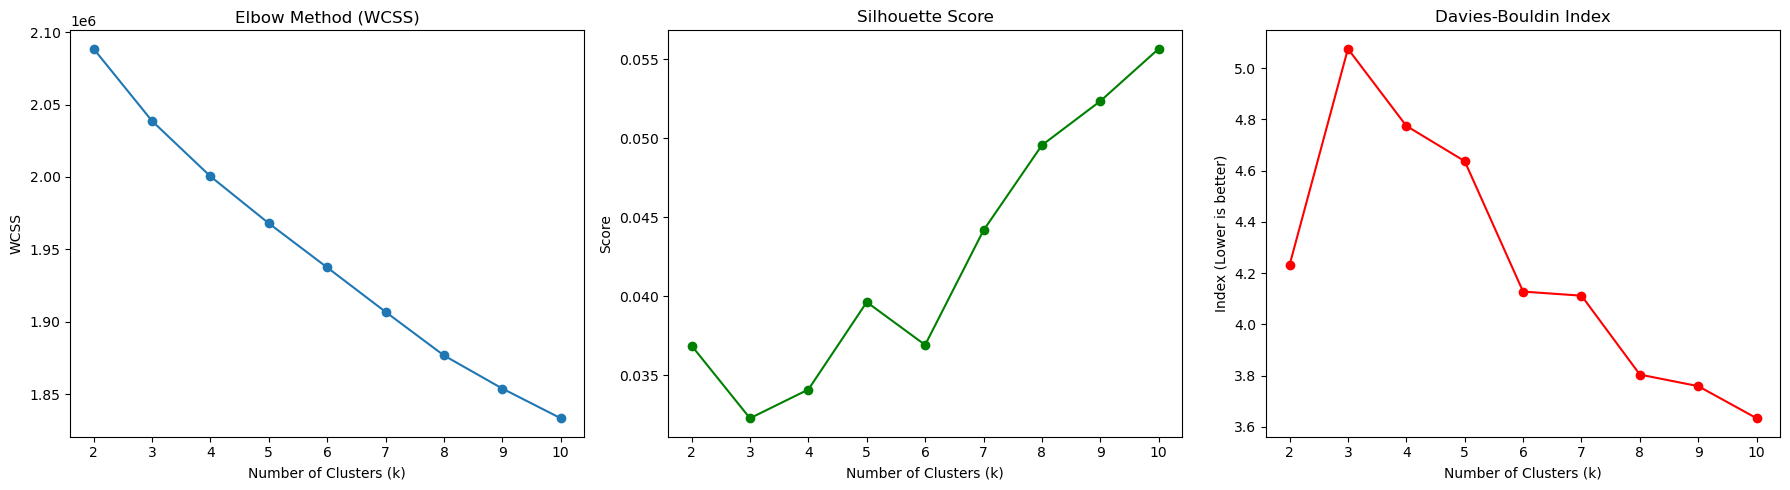


✅ Silhouette Score 기준 최적 k: 10
✅ Davies-Bouldin Index 기준 최적 k: 10


In [66]:
# title_embeddings + duration, title_length, word_count 포함된 통합 피처
result = find_optimal_k(X_combined, k_range=range(2, 11))

In [82]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
title_df['cluster'] = kmeans.fit_predict(X_combined)

for i in range(n_clusters):
    print(f"\n🔹 클러스터 {i} 예시 제목:")
    print(title_df[title_df['cluster'] == i]['title_x'].head(3).to_string(index=False))

print(title_df['cluster'].value_counts().sort_index())


C:\Users\duwjd\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



🔹 클러스터 0 예시 제목:
마라로제엽떡+닭꼬치 꿀조합•노티드 딸기전메뉴🍓먹고 결국 컵라면2개로 마무리•옛날통닭 ...
vlog | 집순이의 주말 삼시세끼 집밥 🛋️ 💭  두툼한 함박스테이크가 올라간 투움...
                                 한국 와서 오지게 먹는 브이로그

🔹 클러스터 1 예시 제목:
          아오니의 혼자 새 닌텐도 사러가는 브이로그★ (feat.세번째섬)
오징어게임2 3분 요약 [Squid Game II 3 Minutes Summary]
               왜 아이폰에서 제일 재밌는 게임이 닌텐도가 되어버렸을까?

🔹 클러스터 2 예시 제목:
       광기 다이어터의 72시간 밀착 브이로그 | 정신 차리고 다이어트 시작🏃‍♀️🚨
        [다이어트브이로그#2] 3일동안 계란이랑 단백질바만 먹으면 얼마나 빠질까?🥚
출산특집#6 먹어야 회복하지!! 자연분만 산모 회복 브이로그, 출산 직후 뭘 먹나? ...

🔹 클러스터 3 예시 제목:
                            오사카&교토 브이로그 • 쇼핑에미띤여자들
[VLOG] 일상 브이로그 | 3월 나의 생일을 맞이하며..🌷 | 이재모피자 제주점 ...
                           둘째 임신했습니다!!!🎉 (연년생 확정😭)

🔹 클러스터 4 예시 제목:
저 드디어 강남에 샵 오픈했어요😭취향 가득 담은 제 샵을 소개합니다🤍 | 인테리어 브...
                                  나 말고 송혜교 브이로그...
 vlog 딸빼고 엄마아빠 데이트👩‍❤‍👨리빙페어, 하이디라오 첫도전, 커트러리&잠옷 쇼핑

🔹 클러스터 5 예시 제목:
                  집도 없고 차도 없는 서민의 인생 첫 명품하울 브이로그
페라리의 나라에서 온 이탈리아 장인어른이 제네시스G90을 보고 두눈을 의심한 이유 ㅎㅎ
                               천만원짜리 카니발 풀옵션 만들

In [87]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 결과 저장용 리스트
cluster_results = []

# 타겟 변수 (로그 변환한 조회수)
df['target'] = np.log1p(df['view_count'])  # views 컬럼명에 따라 조정

# 사용할 feature 컬럼 지정 (title_length, duration, 색상, 객체 등 자유롭게)
feature_cols = [
    'duration', 'subscriber_count', 'brightness', 'contrast',
       'title_length', 'word_count', 'emoji_count',
       'special_char_count', 'is_clickbait', 'has_question_mark',
       'has_exclamation', 'pub_year', 'pub_month', 'pub_weekday', 'color_red',
       'color_blue', 'color_green', 'color_yellow', 'color_purple',
       'color_brown', 'color_grey', 'color_white', 'color_pink',
       'person_count', 'object_count', 'has_text', 'person_left',
       'person_middle', 'person_right', 'person_small', 'person_medium',
       'person_large', 'text_left', 'text_middle', 'text_right', 'text_small',
       'text_medium', 'text_large'
]

# 군집별로 반복
for cluster_id in sorted(df['cluster'].unique()):
    cluster_df = df[df['cluster'] == cluster_id]
    
    if len(cluster_df) < 20:
        print(f"클러스터 {cluster_id} 데이터 수가 적어 스킵됨: {len(cluster_df)}개")
        continue

    X = cluster_df[feature_cols]
    y = cluster_df['target']

    # 훈련/테스트 분리
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 모델 학습
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)

    # 예측
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # 결과 저장
    cluster_results.append({
        'cluster': cluster_id,
        'rmse': rmse,
        'r2': r2,
        'sample_size': len(cluster_df)
    })

    print(f"클러스터 {cluster_id}: RMSE = {rmse:.4f}, R² = {r2:.4f}")


클러스터 0: RMSE = 1.1829, R² = 0.6026
클러스터 1: RMSE = 1.0515, R² = 0.5166
클러스터 2: RMSE = 1.1980, R² = 0.6830
클러스터 3: RMSE = 1.6990, R² = 0.3217
클러스터 4: RMSE = 1.0337, R² = 0.5816
클러스터 5: RMSE = 1.1968, R² = 0.3005
클러스터 6: RMSE = 1.7755, R² = 0.2649
클러스터 7: RMSE = 1.6063, R² = 0.4719
클러스터 8: RMSE = 1.1273, R² = 0.5080
클러스터 9: RMSE = 1.9965, R² = 0.0978


In [155]:
### 클러스터 quantile 나눠서 다시 해보기
cluster_9_df = df[df['cluster'] == 9]
q98 = cluster_9_df['view_count'].quantile(0.98)
trimmed_df = cluster_9_df[cluster_9_df['view_count'] <= q98].copy()

# 타깃: 로그 변환된 조회수
trimmed_df['target'] = np.log1p(trimmed_df['view_count'])

X = trimmed_df[feature_cols]
y = trimmed_df['target']

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# 예측 및 성능 평가
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}")

RMSE: 1.8615, R²: 0.2066


### 재클러스터링 (R스퀘어값 낮은 5,6,9만)

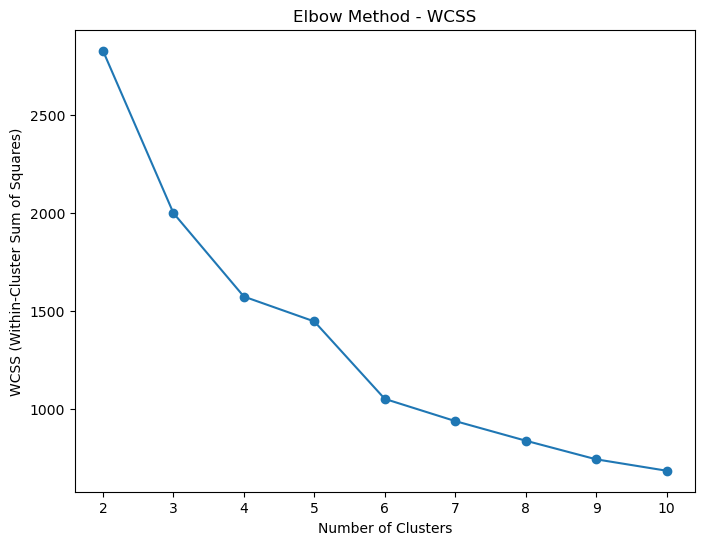

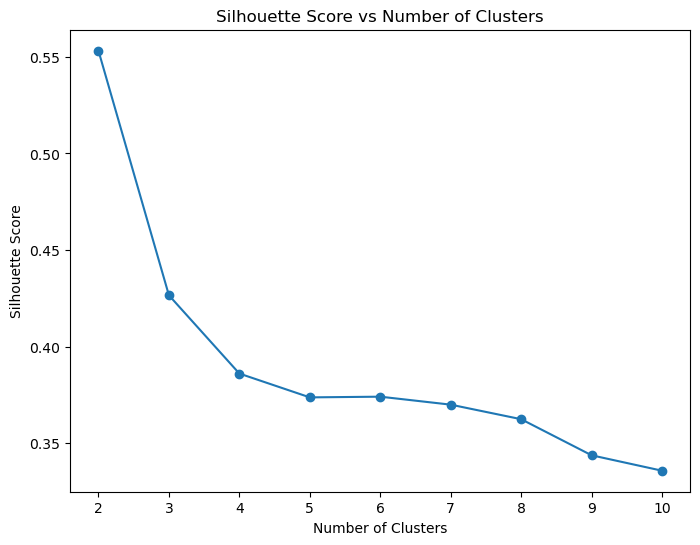

Optimal number of clusters (based on silhouette score): 2


In [137]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.preprocessing import StandardScaler

# 1. 파일 로드
df = title_df
embeddings_df = pd.read_csv("title_embeddings.csv")  # title_embeddings 저장된 csv

# 2. 필요한 컬럼 확인
meta_features = ['duration', 'title_length', 'word_count']
assert all(col in df.columns for col in meta_features + ['cluster'])

# 3. 타겟 클러스터만 선택
target_clusters = [8,9,10]
sub_df = df[df['cluster'].isin(target_clusters)].copy()

# 4. 임베딩 연결 (video_id 등으로 merge)
sub_df = sub_df.merge(embeddings_df, on='video_id', how='left')

# 5. 임베딩 컬럼 리스트로 변환
embedding_cols = [col for col in embeddings_df.columns if col.startswith('embed_')]
embedding_matrix = sub_df[embedding_cols].values

# 6. 메타 정규화
from sklearn.preprocessing import StandardScaler
meta_scaled = StandardScaler().fit_transform(sub_df[meta_features].fillna(0))

# 7. 벡터 결합
X_combined = np.hstack([meta_scaled, embedding_matrix])

# 8. 최적 클러스터 수 찾기 (Elbow Method와 Silhouette Score 사용)

# Elbow Method (WCSS)
wcss = []
silhouette_scores = []
max_clusters = 10  # 최대로 시도할 클러스터 수

for n_clusters in range(2, max_clusters + 1):  # 2부터 max_clusters까지 클러스터 수 변화
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
    kmeans.fit(X_combined)
    
    # WCSS 계산 (Elbow Method용)
    wcss.append(kmeans.inertia_)
    
    # Silhouette Score 계산
    score = silhouette_score(X_combined, kmeans.labels_)
    silhouette_scores.append(score)

# Elbow Method 그래프
plt.figure(figsize=(8, 6))
plt.plot(range(2, max_clusters + 1), wcss, marker='o')
plt.title('Elbow Method - WCSS')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()

# Silhouette Score 그래프
plt.figure(figsize=(8, 6))
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# 최적 클러스터 수 선택 (Silhouette Score 기준)
optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2  # 최대값에 해당하는 클러스터 수
print(f"Optimal number of clusters (based on silhouette score): {optimal_clusters}")

# 9. KMeans 클러스터링 (최적 클러스터 수 사용)
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init="auto")
sub_df['recluster'] = kmeans.fit_predict(X_combined)

DBSCAN Silhouette Score: 0.33377634570469844


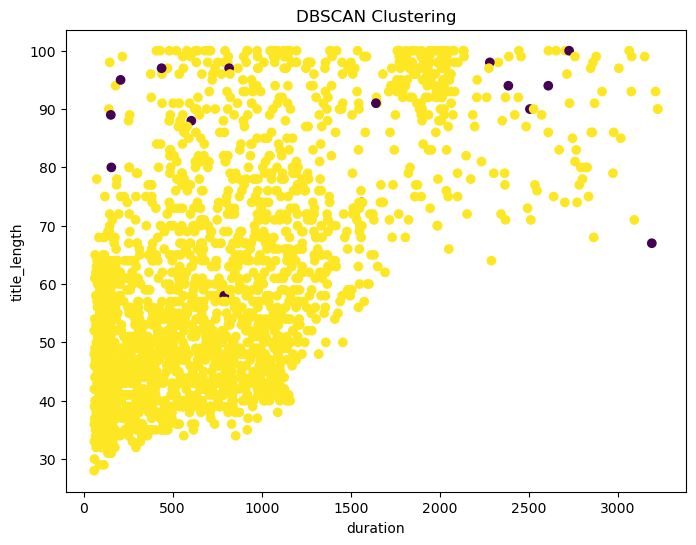

Agglomerative Clustering Silhouette Score: 0.36705815259975544


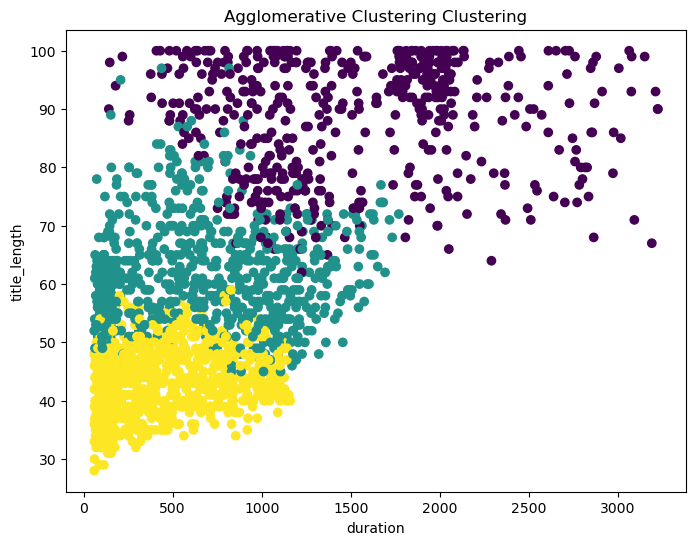

Gaussian Mixture Model Silhouette Score: 0.22667807669581833


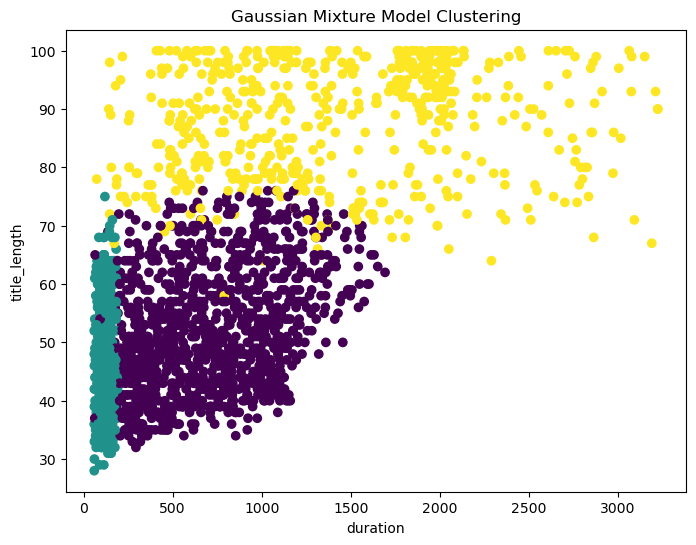

      video_id  recluster
0  DePBBfhQfGE          0
1  vtQ0KhiEP9U          2
2  4p497_IPaSU          0
3  kuFVtsAkgzI          2
4  SuWGN3kvVfo          2


In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# 1. 파일 로드
df = title_df
embeddings_df = pd.read_csv("title_embeddings.csv")  # title_embeddings 저장된 csv

# 2. 필요한 컬럼 확인
meta_features = ['duration', 'title_length', 'word_count']
assert all(col in df.columns for col in meta_features + ['cluster'])

# 3. 타겟 클러스터만 선택
target_clusters = [8,9]
sub_df = df[df['cluster'].isin(target_clusters)].copy()

# 4. 임베딩 연결 (video_id 등으로 merge)
sub_df = sub_df.merge(embeddings_df, on='video_id', how='left')

# 5. 임베딩 컬럼 리스트로 변환
embedding_cols = [col for col in embeddings_df.columns if col.startswith('embed_')]
embedding_matrix = sub_df[embedding_cols].values

# 6. 메타 정규화
meta_scaled = StandardScaler().fit_transform(sub_df[meta_features].fillna(0))

# 7. 벡터 결합
X_combined = np.hstack([meta_scaled, embedding_matrix])

# 클러스터링 알고리즘 리스트
clustering_algorithms = {
    'DBSCAN': DBSCAN(eps=0.5, min_samples=5),
    'Agglomerative Clustering': AgglomerativeClustering(n_clusters=3),
    'Gaussian Mixture Model': GaussianMixture(n_components=3, random_state=42)
}

# 8. 클러스터링 알고리즘 수행 및 성능 평가
for name, algorithm in clustering_algorithms.items():
    sub_df['recluster'] = algorithm.fit_predict(X_combined)
    
    # Silhouette Score 계산
    if len(set(sub_df['recluster'])) > 1:  # 군집이 1개일 경우는 Silhouette Score 계산 안함
        score = silhouette_score(X_combined, sub_df['recluster'])
        print(f"{name} Silhouette Score: {score}")
    else:
        print(f"{name} - No valid clusters formed.")
    
    # 결과 시각화
    plt.figure(figsize=(8, 6))
    plt.scatter(sub_df[meta_features[0]], sub_df[meta_features[1]], c=sub_df['recluster'], cmap='viridis')
    plt.title(f'{name} Clustering')
    plt.xlabel(meta_features[0])
    plt.ylabel(meta_features[1])
    plt.show()

# 결과 확인
print(sub_df[['video_id', 'recluster']].head())

In [139]:
print(sub_df['recluster'].value_counts().sort_index())

0     691
1    1727
Name: recluster, dtype: int64


In [141]:
# 9. 기존 df에 반영
for i in range(len(sub_df)):
    df.iloc[sub_df.iloc[i,0], 30] = sub_df.iloc[i,34] + 100  # 예: 새 cluster 100~102로 할당
print(df['cluster'].value_counts().sort_index())

0       697
1       225
2       264
3       452
4      1678
5       219
6       766
7       589
100     691
101    1727
Name: cluster, dtype: int64


In [143]:
cluster_mapping = {
    0: 0,
    1: 1,
    2: 2,
    3: 3,
    4: 4,
    5: 5,
    6: 6,
    7: 7,
    100: 8,
    101: 9
}

# 'cluster' 칼럼에서 기존 값을 새로운 값으로 변환
df['cluster'] = df['cluster'].replace(cluster_mapping)

In [148]:
#df.to_csv('model_datas.csv', encoding='utf-8-sig')

In [197]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from tqdm import tqdm

# 로그 변환된 타겟 생성
df['target'] = np.log1p(df['view_count'])

# 사용할 회귀 모델들 정의
model_list = {
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "LightGBM": LGBMRegressor(random_state=42,
    min_data_in_leaf=5,         
    min_gain_to_split=0.0,       
    n_estimators=100,
    learning_rate=0.05),
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

# 결과 저장용 리스트
cluster_model_results = []

# 군집별 반복
for cluster_id in sorted(df['cluster'].unique()):
    cluster_df = df[df['cluster'] == cluster_id].copy()

    if len(cluster_df) < 20:
        print(f"클러스터 {cluster_id}은 샘플 부족 → 스킵됨 ({len(cluster_df)}개)")
        continue

    X = cluster_df[feature_cols]
    y = cluster_df['target']

    # 훈련/테스트 분리
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    best_model_name = None
    best_model_score = -np.inf
    best_rmse = None

    for name, model in model_list.items():
        try:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)

            if r2 > best_model_score:
                best_model_name = name
                best_model_score = r2
                best_rmse = rmse

        except Exception as e:
            print(f"[{name}] 모델 오류 in 클러스터 {cluster_id}: {e}")
            continue

    cluster_model_results.append({
        "cluster": cluster_id,
        "best_model": best_model_name,
        "rmse": round(best_rmse, 4),
        "r2": round(best_model_score, 4),
        "sample_size": len(cluster_df)
    })

results_df = pd.DataFrame(cluster_model_results).sort_values(by="r2", ascending=False)
print(results_df)

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1287
[LightGBM] [Info] Number of data points in the train set: 1393, number of used features: 38
[LightGBM] [Info] Start training from score 11.616164
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_d

## 모델학습

In [11]:
import optuna
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 각 클러스터에 대해 최적 모델 지정
cluster_best_models = {
    0: "LightGBM",
    1: "GradientBoosting",
    2: "RandomForest",
    3: "LightGBM",
    4: "LightGBM",
    5: "RandomForest",
    6: "RandomForest",
    7: "XGBoost",
    8: "LightGBM",
    9: "RandomForest"
}

# 모델 저장용 딕셔너리
trained_models = []
optuna_results = []

# 피처 컬럼
feature_cols = [
    'duration', 'subscriber_count', 'brightness', 'contrast',
    'title_length', 'word_count', 'emoji_count', 
    'special_char_count', 'is_clickbait', 'has_question_mark',
    'has_exclamation', 'pub_year', 'pub_month', 'pub_weekday', 'color_red',
    'color_blue', 'color_green', 'color_yellow', 'color_purple',
    'color_brown', 'color_grey', 'color_white', 'color_pink',
    'person_count', 'object_count', 'has_text', 'person_left',
    'person_middle', 'person_right', 'person_small', 'person_medium',
    'person_large', 'text_left', 'text_middle', 'text_right', 'text_small',
    'text_medium', 'text_large'
]

# 각 모델에 대한 최적화 함수 정의
def objective_rf(trial, X_train, y_train, X_val, y_val):
    try:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
        max_depth = trial.suggest_int('max_depth', 3, 15)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20, step=2)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20, step=2)

        rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,
                                   min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        return rmse
    except Exception as e:
        print(f"Error in trial: {e}")
        return float("inf")  # 실패 시 높은 값 반환

import xgboost as xgb

def objective_xgboost(trial, X_train, y_train, X_val, y_val):
    try:
        # 파라미터 범위 설정
        param = {
            'objective': 'reg:squarederror',  # 회귀 문제에 맞게 설정
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
        }

        # XGBoost 모델 학습
        model = xgb.XGBRegressor(**param, random_state=42)
        model.fit(X_train, y_train)

        # 예측 및 RMSE 계산
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))

        return rmse
    
    except Exception as e:
        print(f"Error in trial: {e}")
        return float("inf")  # 실패한 트라이얼을 높은 값으로 처리하여 무시

def objective_gb(trial, X_train, y_train, X_val, y_val):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20, step=2)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20, step=2)

    gb = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth,
                                   learning_rate=learning_rate, min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf, random_state=42)
    gb.fit(X_train, y_train)
    y_pred = gb.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse

def objective_lgb(trial, X_train, y_train, X_val, y_val):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1, log=True)
    min_child_samples = trial.suggest_int('min_child_samples', 5, 50, step=5)

    lgb = LGBMRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate,
                        min_child_samples=min_child_samples, random_state=42)
    lgb.fit(X_train, y_train)
    y_pred = lgb.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse

# 모델 학습 및 최적화
for cluster_id, model_name in tqdm(cluster_best_models.items()):
    # 해당 클러스터 데이터 선택
    cluster_df = df[df['cluster'] == cluster_id].copy()
    X = cluster_df[feature_cols]
    y = np.log1p(cluster_df['view_count'])  # 타겟: log(1+view_count)

    # 훈련 데이터와 검증 데이터로 분리
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Optuna 최적화 함수 선택
    def opt_objective(trial):
        if model_name == "RandomForest":
            return objective_rf(trial, X_train, y_train, X_val, y_val)
        elif model_name == "GradientBoosting":
            return objective_gb(trial, X_train, y_train, X_val, y_val)
        elif model_name == "XGBoost":
            return objective_xgboost(trial, X_train, y_train, X_val, y_val)
        elif model_name == "LightGBM":
            return objective_lgb(trial, X_train, y_train, X_val, y_val)

    # Optuna 최적화
    study = optuna.create_study(direction="minimize")
    study.optimize(opt_objective, n_trials=20)

    # 최적 파라미터 가져오기
    if study.best_trial:
        best_params = study.best_trial.params
    else:
        print("No trials completed successfully.")


    # 최적 파라미터로 모델 재학습
    if model_name == "RandomForest":
        model = RandomForestRegressor(**best_params, random_state=42)
    elif model_name == "GradientBoosting":
        model = GradientBoostingRegressor(**best_params, random_state=42)
    elif model_name == "LightGBM":
        model = LGBMRegressor(**best_params, random_state=42)

    model.fit(X_train, y_train)
    trained_models.append(model)

    # 예측 및 성능 평가
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)

    optuna_results.append({
        "cluster": cluster_id,
        "model": model_name,
        "rmse": round(rmse, 4),
        "r2": round(r2, 4),
        "best_params": best_params
    })

# 결과 확인
result_df = pd.DataFrame(optuna_results).sort_values(by="r2", ascending=False)
print(result_df)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s][I 2025-05-15 11:08:20,010] A new study created in memory with name: no-name-80790e59-b12a-46c2-a4a4-c21b7959c353


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1046
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 36
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-05-15 11:08:21,048] Trial 0 finished with value: 1.230497999239516 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.008232989277488246, 'min_child_samples': 20}. Best is trial 0 with value: 1.230497999239516.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1035
[LightGBM] [Info] Number of data points in the train set: 557, nu

[I 2025-05-15 11:08:21,649] Trial 1 finished with value: 1.5545622215828743 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.0013563710354907626, 'min_child_samples': 40}. Best is trial 0 with value: 1.230497999239516.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1048
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 37
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-05-15 11:08:22,702] Trial 2 finished with value: 1.3304382060332829 and parameters: {'n_estimators': 700, 'max_depth': 6, 'learning_rate': 0.0014342053997537358, 'min_child_samples': 10}. Best is trial 0 with value: 1.230497999239516.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1035
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 32
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-05-15 11:08:23,119] Trial 3 finished with value: 1.2440156369774689 and parameters: {'n_estimators': 600, 'max_depth': 7, 'learning_rate': 0.0031135511739786665, 'min_child_samples': 35}. Best is trial 0 with value: 1.230497999239516.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1039
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 34
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-05-15 11:08:23,797] Trial 4 finished with value: 1.3048447008083228 and parameters: {'n_estimators': 700, 'max_depth': 9, 'learning_rate': 0.0017207079851557798, 'min_child_samples': 30}. Best is trial 0 with value: 1.230497999239516.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1035
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 32
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-05-15 11:08:24,631] Trial 5 finished with value: 1.2844905816699785 and parameters: {'n_estimators': 700, 'max_depth': 13, 'learning_rate': 0.001900583734512685, 'min_child_samples': 35}. Best is trial 0 with value: 1.230497999239516.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-15 11:08:26,218] Trial 6 finished with value: 1.1862680260992082 and parameters: {'n_estimators': 900, 'max_depth': 6, 'learning_rate': 0.027073924663384055, 'min_child_samples': 5}. Best is trial 6 with value: 1.1862680260992082.
[I 2025-05-15 11:08:26,376] Trial 7 finished with value: 1.1998736404631207 and parameters: {'n_estimators': 100, 'max_depth': 11, 'learning_rate': 0.0361923330683393, 'min_child_samples': 20}. Best is trial 6 with value: 1.1862680260992082.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1046
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 36
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-05-15 11:08:28,927] Trial 8 finished with value: 1.2622614170408533 and parameters: {'n_estimators': 900, 'max_depth': 13, 'learning_rate': 0.0014687405996372212, 'min_child_samples': 5}. Best is trial 6 with value: 1.1862680260992082.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1048
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 37
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-05-15 11:08:30,355] Trial 9 finished with value: 1.2392391105018237 and parameters: {'n_estimators': 700, 'max_depth': 11, 'learning_rate': 0.022137197667731465, 'min_child_samples': 10}. Best is trial 6 with value: 1.1862680260992082.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1035
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 32
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-05-15 11:08:30,992] Trial 10 finished with value: 1.2393213468218351 and parameters: {'n_estimators': 1000, 'max_depth': 4, 'learning_rate': 0.09851012591606405, 'min_child_samples': 50}. Best is trial 6 with value: 1.1862680260992082.
[I 2025-05-15 11:08:31,146] Trial 11 finished with value: 1.1987317163938367 and parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.03769096052153708, 'min_child_samples': 20}. Best is trial 6 with value: 1.1862680260992082.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1046
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 36
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-05-15 11:08:31,419] Trial 12 finished with value: 1.1888463351291803 and parameters: {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.03341168099226005, 'min_child_samples': 20}. Best is trial 6 with value: 1.1862680260992082.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-15 11:08:31,822] Trial 13 finished with value: 1.1664555247215436 and parameters: {'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.012649408672812817, 'min_child_samples': 5}. Best is trial 13 with value: 1.1664555247215436.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-15 11:08:32,460] Trial 14 finished with value: 1.19286081388146 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.011362120410846539, 'min_child_samples': 5}. Best is trial 13 with value: 1.1664555247215436.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-15 11:08:33,995] Trial 15 finished with value: 1.2201533338534947 and parameters: {'n_estimators': 900, 'max_depth': 8, 'learning_rate': 0.007233663641436136, 'min_child_samples': 10}. Best is trial 13 with value: 1.1664555247215436.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1046
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 36
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-05-15 11:08:34,505] Trial 16 finished with value: 1.1852407522873172 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.01580563899604936, 'min_child_samples': 15}. Best is trial 13 with value: 1.1664555247215436.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-15 11:08:35,066] Trial 17 finished with value: 1.2080894214289193 and parameters: {'n_estimators': 300, 'max_depth': 15, 'learning_rate': 0.0146063257544561, 'min_child_samples': 15}. Best is trial 13 with value: 1.1664555247215436.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1046
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 36
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-05-15 11:08:35,544] Trial 18 finished with value: 1.2371616326165875 and parameters: {'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.004727170404328181, 'min_child_samples': 15}. Best is trial 13 with value: 1.1664555247215436.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-15 11:08:36,389] Trial 19 finished with value: 1.216333018869923 and parameters: {'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.018441566045949397, 'min_child_samples': 25}. Best is trial 13 with value: 1.1664555247215436.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 10%|████████▎                                                                          | 1/10 [00:16<02:31, 16.82s/it][I 2025-05-15 11:08:36,828] A new study created in memory with name: no-name-cc07e244-e9c3-4c12-8ed3-123ac0643eda


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\duwjd\anaconda3\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 20] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 19].
  warnings.warn(
[I 2025-05-15 11:08:39,099] Trial 0 finished with value: 1.2107359401061313 and parameters: {'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.0024163674294455473, 'min_samples_split': 14, 'min_samples_leaf': 19}. Best is trial 0 with value: 1.2107359401061313.
C:\Users\duwjd\anaconda3\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 20] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 19].
  warnings.warn(
[I 2025-05-15 11:08:39,827] Trial 1 finished with value: 1.226124024874183 and parameters: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.0048107335094631585, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 0 with value: 1.2107359401061313.
C:\Users

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 724
[LightGBM] [Info] Number of data points in the train set: 361, number of used features: 32
[LightGBM] [Info] Start training from score 11.665486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-05-15 11:12:02,523] Trial 0 finished with value: 0.9899369922329653 and parameters: {'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.00839258145991438, 'min_child_samples': 25}. Best is trial 0 with value: 0.9899369922329653.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 726
[LightGBM] [Info] Number of data points in the train set: 361, number of used features: 33
[LightGBM] [Info] Start training from score 11.665486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-05-15 11:12:03,298] Trial 1 finished with value: 1.0123413799597554 and parameters: {'n_estimators': 800, 'max_depth': 7, 'learning_rate': 0.01678929242007686, 'min_child_samples': 15}. Best is trial 0 with value: 0.9899369922329653.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 724
[LightGBM] [Info] Number of data points in the train set: 361, number of used features: 32
[LightGBM] [Info] Start training from score 11.665486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-05-15 11:12:03,744] Trial 2 finished with value: 1.008456065797307 and parameters: {'n_estimators': 400, 'max_depth': 8, 'learning_rate': 0.04330730429728916, 'min_child_samples': 25}. Best is trial 0 with value: 0.9899369922329653.
[I 2025-05-15 11:12:03,819] Trial 3 finished with value: 1.3455379384270265 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.004835728936574556, 'min_child_samples': 45}. Best is trial 0 with value: 0.9899369922329653.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 722
[LightGBM] [Info] Number of data points in the train set: 361, number of used features: 31
[LightGBM] [Info] Start training from score 11.665486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-05-15 11:12:04,663] Trial 4 finished with value: 1.0830483669466484 and parameters: {'n_estimators': 800, 'max_depth': 7, 'learning_rate': 0.0292382600882971, 'min_child_samples': 10}. Best is trial 0 with value: 0.9899369922329653.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 737
[LightGBM] [Info] Number of data points in the train set: 361, number of used features: 38
[LightGBM] [Info] Start training from score 11.665486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-05-15 11:12:05,692] Trial 5 finished with value: 1.0073979756701876 and parameters: {'n_estimators': 800, 'max_depth': 7, 'learning_rate': 0.011206268517629413, 'min_child_samples': 5}. Best is trial 0 with value: 0.9899369922329653.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 737
[LightGBM] [Info] Number of data points in the train set: 361, number of used features: 38
[LightGBM] [Info] Start training from score 11.665486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-05-15 11:12:06,329] Trial 6 finished with value: 1.0008323425707688 and parameters: {'n_estimators': 400, 'max_depth': 12, 'learning_rate': 0.020140016263270874, 'min_child_samples': 5}. Best is trial 0 with value: 0.9899369922329653.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 722
[LightGBM] [Info] Number of data points in the train set: 361, number of used features: 31
[LightGBM] [Info] Start training from score 11.665486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-05-15 11:12:06,720] Trial 7 finished with value: 1.0082513845006384 and parameters: {'n_estimators': 800, 'max_depth': 4, 'learning_rate': 0.003724253814103104, 'min_child_samples': 35}. Best is trial 0 with value: 0.9899369922329653.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-15 11:12:06,936] Trial 8 finished with value: 1.0190739321592868 and parameters: {'n_estimators': 400, 'max_depth': 8, 'learning_rate': 0.029734792024547783, 'min_child_samples': 40}. Best is trial 0 with value: 0.9899369922329653.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 722
[LightGBM] [Info] Number of data points in the train set: 361, number of used features: 31
[LightGBM] [Info] Start training from score 11.665486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-05-15 11:12:07,072] Trial 9 finished with value: 1.1411610568615038 and parameters: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.005876525416221592, 'min_child_samples': 40}. Best is trial 0 with value: 0.9899369922329653.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 722
[LightGBM] [Info] Number of data points in the train set: 361, number of used features: 31
[LightGBM] [Info] Start training from score 11.665486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-05-15 11:12:07,639] Trial 10 finished with value: 1.246839515372929 and parameters: {'n_estimators': 600, 'max_depth': 15, 'learning_rate': 0.0010814559108804393, 'min_child_samples': 20}. Best is trial 0 with value: 0.9899369922329653.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 724
[LightGBM] [Info] Number of data points in the train set: 361, number of used features: 32
[LightGBM] [Info] Start training from score 11.665486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-05-15 11:12:08,416] Trial 11 finished with value: 1.0350129783597015 and parameters: {'n_estimators': 1000, 'max_depth': 12, 'learning_rate': 0.0929358018995753, 'min_child_samples': 30}. Best is trial 0 with value: 0.9899369922329653.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 737
[LightGBM] [Info] Number of data points in the train set: 361, number of used features: 38
[LightGBM] [Info] Start training from score 11.665486


[I 2025-05-15 11:12:09,422] Trial 12 finished with value: 1.1387801744380093 and parameters: {'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.0021337716997488912, 'min_child_samples': 5}. Best is trial 0 with value: 0.9899369922329653.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 724
[LightGBM] [Info] Number of data points in the train set: 361, number of used features: 32
[LightGBM] [Info] Start training from score 11.665486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-05-15 11:12:10,366] Trial 13 finished with value: 1.024928731772344 and parameters: {'n_estimators': 1000, 'max_depth': 12, 'learning_rate': 0.011184289196423117, 'min_child_samples': 20}. Best is trial 0 with value: 0.9899369922329653.
[I 2025-05-15 11:12:10,588] Trial 14 finished with value: 1.0035266792152577 and parameters: {'n_estimators': 300, 'max_depth': 15, 'learning_rate': 0.0176603878502672, 'min_child_samples': 50}. Best is trial 0 with value: 0.9899369922329653.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 716
[LightGBM] [Info] Number of data points in the train set: 361, number of used features: 29
[LightGBM] [Info] Start training from score 11.665486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-05-15 11:12:11,317] Trial 15 finished with value: 1.0268749432800939 and parameters: {'n_estimators': 600, 'max_depth': 11, 'learning_rate': 0.07896297177954416, 'min_child_samples': 15}. Best is trial 0 with value: 0.9899369922329653.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 724
[LightGBM] [Info] Number of data points in the train set: 361, number of used features: 32
[LightGBM] [Info] Start training from score 11.665486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-05-15 11:12:11,704] Trial 16 finished with value: 0.9694348244404024 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.007448721759688073, 'min_child_samples': 30}. Best is trial 16 with value: 0.9694348244404024.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-15 11:12:12,137] Trial 17 finished with value: 0.964752664279784 and parameters: {'n_estimators': 700, 'max_depth': 3, 'learning_rate': 0.006982366678409321, 'min_child_samples': 30}. Best is trial 17 with value: 0.964752664279784.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-15 11:12:12,667] Trial 18 finished with value: 1.0341725817884508 and parameters: {'n_estimators': 700, 'max_depth': 5, 'learning_rate': 0.0027515064334490574, 'min_child_samples': 30}. Best is trial 17 with value: 0.964752664279784.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-15 11:12:13,010] Trial 19 finished with value: 1.1951012518136852 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.0017339431463810838, 'min_child_samples': 35}. Best is trial 17 with value: 0.964752664279784.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 724
[LightGBM] [Info] Number of data points in the train set: 361, number of used features: 32
[LightGBM] [Info] Start training from score 11.665486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

 40%|█████████████████████████████████▏                                                 | 4/10 [03:53<05:29, 54.97s/it][I 2025-05-15 11:12:13,323] A new study created in memory with name: no-name-dea85042-9d1e-4613-a649-975a4b2692db


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-15 11:12:13,694] Trial 0 finished with value: 1.564337411983764 and parameters: {'n_estimators': 200, 'max_depth': 12, 'learning_rate': 0.027951896020448216, 'min_child_samples': 40}. Best is trial 0 with value: 1.564337411983764.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-ch

[I 2025-05-15 11:12:14,386] Trial 1 finished with value: 1.734979520629697 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.0018902095586498329, 'min_child_samples': 40}. Best is trial 0 with value: 1.564337411983764.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-15 11:12:14,662] Trial 2 finished with value: 1.6172313475920836 and parameters: {'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.022490555340087256, 'min_child_samples': 5}. Best is trial 0 with value: 1.564337411983764.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1395
[LightGBM] [Info] Number of data points in the train set: 1342, number of used features: 38
[LightGBM] [Info] Start training from score 12.274996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-05-15 11:12:15,791] Trial 3 finished with value: 1.5829769634303807 and parameters: {'n_estimators': 700, 'max_depth': 9, 'learning_rate': 0.013497444126957282, 'min_child_samples': 40}. Best is trial 0 with value: 1.564337411983764.
[I 2025-05-15 11:12:16,022] Trial 4 finished with value: 1.6344260511312698 and parameters: {'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.0663689923772504, 'min_child_samples': 25}. Best is trial 0 with value: 1.564337411983764.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1395
[LightGBM] [Info] Number of data points in the train set: 1342, number of used features: 38
[LightGBM] [Info] Start training from score 12.274996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-05-15 11:12:16,945] Trial 5 finished with value: 1.5977019505568346 and parameters: {'n_estimators': 600, 'max_depth': 6, 'learning_rate': 0.005750314769749496, 'min_child_samples': 45}. Best is trial 0 with value: 1.564337411983764.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1395
[LightGBM] [Info] Number of data points in the train set: 1342, number of used features: 38
[LightGBM] [Info] Start training from score 12.274996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-05-15 11:12:17,727] Trial 6 finished with value: 1.6897531128842769 and parameters: {'n_estimators': 800, 'max_depth': 5, 'learning_rate': 0.037836482161389955, 'min_child_samples': 25}. Best is trial 0 with value: 1.564337411983764.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1395
[LightGBM] [Info] Number of data points in the train set: 1342, number of used features: 38
[LightGBM] [Info] Start training from score 12.274996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-05-15 11:12:19,413] Trial 7 finished with value: 1.591370375160683 and parameters: {'n_estimators': 900, 'max_depth': 12, 'learning_rate': 0.0036750939853747062, 'min_child_samples': 50}. Best is trial 0 with value: 1.564337411983764.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1395
[LightGBM] [Info] Number of data points in the train set: 1342, number of used features: 38
[LightGBM] [Info] Start training from score 12.274996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-05-15 11:12:21,014] Trial 8 finished with value: 1.6560016875773047 and parameters: {'n_estimators': 900, 'max_depth': 11, 'learning_rate': 0.04463017221741063, 'min_child_samples': 45}. Best is trial 0 with value: 1.564337411983764.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1395
[LightGBM] [Info] Number of data points in the train set: 1342, number of used features: 38
[LightGBM] [Info] Start training from score 12.274996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-05-15 11:12:21,547] Trial 9 finished with value: 1.6215063801242149 and parameters: {'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.019882849439380092, 'min_child_samples': 15}. Best is trial 0 with value: 1.564337411983764.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-15 11:12:22,223] Trial 10 finished with value: 1.6689024376731527 and parameters: {'n_estimators': 300, 'max_depth': 15, 'learning_rate': 0.09491636219191078, 'min_child_samples': 35}. Best is trial 0 with value: 1.564337411983764.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-15 11:12:22,882] Trial 11 finished with value: 1.5854175688037833 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.010805191840478765, 'min_child_samples': 35}. Best is trial 0 with value: 1.564337411983764.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-15 11:12:23,674] Trial 12 finished with value: 1.5925292481628377 and parameters: {'n_estimators': 400, 'max_depth': 9, 'learning_rate': 0.011834039637116238, 'min_child_samples': 35}. Best is trial 0 with value: 1.564337411983764.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1395
[LightGBM] [Info] Number of data points in the train set: 1342, number of used features: 38
[LightGBM] [Info] Start training from score 12.274996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-05-15 11:12:24,970] Trial 13 finished with value: 1.6248874433094334 and parameters: {'n_estimators': 700, 'max_depth': 15, 'learning_rate': 0.02317408301046595, 'min_child_samples': 50}. Best is trial 0 with value: 1.564337411983764.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1395
[LightGBM] [Info] Number of data points in the train set: 1342, number of used features: 38
[LightGBM] [Info] Start training from score 12.274996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-05-15 11:12:25,701] Trial 14 finished with value: 1.6356157628756507 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.005986643196645186, 'min_child_samples': 30}. Best is trial 0 with value: 1.564337411983764.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1395
[LightGBM] [Info] Number of data points in the train set: 1342, number of used features: 38
[LightGBM] [Info] Start training from score 12.274996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-05-15 11:12:27,519] Trial 15 finished with value: 1.6688932769295366 and parameters: {'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.0013030502691797705, 'min_child_samples': 40}. Best is trial 0 with value: 1.564337411983764.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1395
[LightGBM] [Info] Number of data points in the train set: 1342, number of used features: 38
[LightGBM] [Info] Start training from score 12.274996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-05-15 11:12:29,288] Trial 16 finished with value: 1.635946257946889 and parameters: {'n_estimators': 700, 'max_depth': 14, 'learning_rate': 0.015729242560400748, 'min_child_samples': 30}. Best is trial 0 with value: 1.564337411983764.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1395
[LightGBM] [Info] Number of data points in the train set: 1342, number of used features: 38
[LightGBM] [Info] Start training from score 12.274996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-05-15 11:12:30,584] Trial 17 finished with value: 1.6627754945015873 and parameters: {'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.03542604081542495, 'min_child_samples': 20}. Best is trial 0 with value: 1.564337411983764.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1395
[LightGBM] [Info] Number of data points in the train set: 1342, number of used features: 38
[LightGBM] [Info] Start training from score 12.274996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-05-15 11:12:31,068] Trial 18 finished with value: 1.67204147786659 and parameters: {'n_estimators': 200, 'max_depth': 13, 'learning_rate': 0.006321127332219696, 'min_child_samples': 40}. Best is trial 0 with value: 1.564337411983764.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-15 11:12:31,908] Trial 19 finished with value: 1.6455824454017198 and parameters: {'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.0038381136955956624, 'min_child_samples': 45}. Best is trial 0 with value: 1.564337411983764.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000994 secon

 50%|█████████████████████████████████████████▌                                         | 5/10 [04:12<03:30, 42.01s/it][I 2025-05-15 11:12:32,355] A new study created in memory with name: no-name-fd1d6a2d-82e4-4f13-aa4a-4e3cd931f673


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\duwjd\anaconda3\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 20] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 19].
  warnings.warn(
[I 2025-05-15 11:12:34,082] Trial 0 finished with value: 1.0486511147821003 and parameters: {'n_estimators': 200, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 5}. Best is trial 0 with value: 1.0486511147821003.
C:\Users\duwjd\anaconda3\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 20] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 19].
  warnings.warn(
[I 2025-05-15 11:12:41,096] Trial 1 finished with value: 1.1025958410464445 and parameters: {'n_estimators': 900, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 7}. Best is trial 0 with value: 1.0486511147821003.
C:\Users\duwjd\anaconda3\Lib\site-packages\optuna\distributions.py:699: UserWarning: The

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 552, number of used features: 37
[LightGBM] [Info] Start training from score 11.277799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-05-15 11:17:20,323] Trial 1 finished with value: 1.4513337376309017 and parameters: {'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.04325720191311909, 'min_child_samples': 10}. Best is trial 0 with value: 1.4092254829611046.
[I 2025-05-15 11:17:20,507] Trial 2 finished with value: 1.7092740286707717 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.0011205062829983284, 'min_child_samples': 5}. Best is trial 0 with value: 1.4092254829611046.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 941
[LightGBM] [Info] Number of data points in the train set: 552, number of used features: 38
[LightGBM] [Info] Start training from score 11.277799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-05-15 11:17:21,112] Trial 3 finished with value: 1.5788684832105881 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.001355187300608035, 'min_child_samples': 35}. Best is trial 0 with value: 1.4092254829611046.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-15 11:17:22,123] Trial 4 finished with value: 1.4467083653700619 and parameters: {'n_estimators': 900, 'max_depth': 11, 'learning_rate': 0.014644206323957316, 'min_child_samples': 20}. Best is trial 0 with value: 1.4092254829611046.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 552, number of used features: 37
[LightGBM] [Info] Start training from score 11.277799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-05-15 11:17:22,552] Trial 5 finished with value: 1.4791497259292463 and parameters: {'n_estimators': 400, 'max_depth': 8, 'learning_rate': 0.01990337443684572, 'min_child_samples': 15}. Best is trial 0 with value: 1.4092254829611046.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 552, number of used features: 37
[LightGBM] [Info] Start training from score 11.277799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-05-15 11:17:23,039] Trial 6 finished with value: 1.499767998838392 and parameters: {'n_estimators': 600, 'max_depth': 13, 'learning_rate': 0.02331580438023244, 'min_child_samples': 35}. Best is trial 0 with value: 1.4092254829611046.
[I 2025-05-15 11:17:23,159] Trial 7 finished with value: 1.513550870686432 and parameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.049683418234155986, 'min_child_samples': 10}. Best is trial 0 with value: 1.4092254829611046.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory

[I 2025-05-15 11:17:23,341] Trial 8 finished with value: 1.5055042566637489 and parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.03970890555485052, 'min_child_samples': 15}. Best is trial 0 with value: 1.4092254829611046.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 552, number of used features: 37
[LightGBM] [Info] Start training from score 11.277799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-05-15 11:17:23,575] Trial 9 finished with value: 1.6492272965121515 and parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.0019427871349871426, 'min_child_samples': 10}. Best is trial 0 with value: 1.4092254829611046.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-15 11:17:24,125] Trial 10 finished with value: 1.5035315090949002 and parameters: {'n_estimators': 700, 'max_depth': 10, 'learning_rate': 0.004978806676791337, 'min_child_samples': 50}. Best is trial 0 with value: 1.4092254829611046.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 552, number of used features: 37
[LightGBM] [Info] Start training from score 11.277799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-05-15 11:17:25,311] Trial 11 finished with value: 1.4599681218211988 and parameters: {'n_estimators': 900, 'max_depth': 11, 'learning_rate': 0.09835979218679854, 'min_child_samples': 25}. Best is trial 0 with value: 1.4092254829611046.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 552, number of used features: 37
[LightGBM] [Info] Start training from score 11.277799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-05-15 11:17:26,374] Trial 12 finished with value: 1.4281478310271276 and parameters: {'n_estimators': 800, 'max_depth': 13, 'learning_rate': 0.007362300400041157, 'min_child_samples': 25}. Best is trial 0 with value: 1.4092254829611046.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 552, number of used features: 37
[LightGBM] [Info] Start training from score 11.277799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-05-15 11:17:27,063] Trial 13 finished with value: 1.5149308712256968 and parameters: {'n_estimators': 700, 'max_depth': 15, 'learning_rate': 0.005621192471558138, 'min_child_samples': 35}. Best is trial 0 with value: 1.4092254829611046.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-15 11:17:27,268] Trial 14 finished with value: 1.6147084445005793 and parameters: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.007729228374359601, 'min_child_samples': 30}. Best is trial 0 with value: 1.4092254829611046.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 552, number of used features: 37
[LightGBM] [Info] Start training from score 11.277799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-05-15 11:17:27,959] Trial 15 finished with value: 1.5031947664315213 and parameters: {'n_estimators': 800, 'max_depth': 15, 'learning_rate': 0.004335576586803558, 'min_child_samples': 45}. Best is trial 0 with value: 1.4092254829611046.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-15 11:17:28,593] Trial 16 finished with value: 1.4559853485921685 and parameters: {'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.09577229997467522, 'min_child_samples': 25}. Best is trial 0 with value: 1.4092254829611046.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-15 11:17:29,205] Trial 17 finished with value: 1.484640492017142 and parameters: {'n_estimators': 600, 'max_depth': 9, 'learning_rate': 0.010963726142803058, 'min_child_samples': 30}. Best is trial 0 with value: 1.4092254829611046.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-15 11:17:30,411] Trial 18 finished with value: 1.496950110767459 and parameters: {'n_estimators': 800, 'max_depth': 13, 'learning_rate': 0.002315358005243825, 'min_child_samples': 20}. Best is trial 0 with value: 1.4092254829611046.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 552, number of used features: 37
[LightGBM] [Info] Start training from score 11.277799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-05-15 11:17:30,942] Trial 19 finished with value: 1.546160396749428 and parameters: {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.0033256085460398265, 'min_child_samples': 40}. Best is trial 0 with value: 1.4092254829611046.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 552, number of used features: 37
[LightGBM] [Info] Start training from score 11.277799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [09:11<00:55, 55.88s/it][I 2025-05-15 11:17:31,172] A new study created in memory with name: no-name-ee5977ba-0343-4007-a354-060b97c42cbf
C:\Users\duwjd\anaconda3\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 20] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 19].
  warnings.warn(
[I 2025-05-15 11:17:34,024] Trial 0 finished with value: 1.8998048111477872 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 19}. Best is trial 0 with value: 1.8998048111477872.
C:\Users\duwjd\anaconda3\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 20] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 19].
  warnings.warn(
[I 2025-05-15 11:17:48,364] Trial 1 finished with value: 1.9190141748501253 and pa

   cluster             model    rmse      r2  \
2        2      RandomForest  1.2007  0.6815   
3        3          LightGBM  0.9648  0.6355   
1        1  GradientBoosting  0.9150  0.6339   
0        0          LightGBM  1.1665  0.6136   
5        5      RandomForest  1.0370  0.5836   
4        4          LightGBM  1.5643  0.4991   
6        6      RandomForest  1.3646  0.4577   
7        7           XGBoost  1.4691  0.4042   
8        8          LightGBM  1.4092  0.3589   
9        9      RandomForest  1.8188  0.2729   

                                         best_params  
2  {'n_estimators': 200, 'max_depth': 11, 'min_sa...  
3  {'n_estimators': 700, 'max_depth': 3, 'learnin...  
1  {'n_estimators': 800, 'max_depth': 11, 'learni...  
0  {'n_estimators': 400, 'max_depth': 4, 'learnin...  
5  {'n_estimators': 100, 'max_depth': 15, 'min_sa...  
4  {'n_estimators': 200, 'max_depth': 12, 'learni...  
6  {'n_estimators': 100, 'max_depth': 12, 'min_sa...  
7  {'max_depth': 12, 'learning_

In [13]:
result_df.to_csv('model_result.csv', encoding='utf-8')

In [187]:
import joblib
import os

save_dir = r"C:\web\saved_models"
os.makedirs(save_dir, exist_ok=True)

# trained_models에서 각 모델 저장
for cluster_id, model in enumerate(trained_models):  # 리스트 인덱스에 따라 모델 순차적으로 저장
    try:
        # 저장 경로 지정
        path = os.path.join(save_dir, f"model_cluster_{cluster_id+7}.pkl")
        
        # 모델 저장
        joblib.dump(model, path)
        
        # 저장 완료 출력
        print(f"클러스터 {cluster_id+7} 모델 저장 완료 → {path}")
    
    except Exception as e:
        print(f"클러스터 {cluster_id+7} 모델 저장 중 오류 발생: {e}")

클러스터 7 모델 저장 완료 → C:\web\saved_models\model_cluster_7.pkl
클러스터 8 모델 저장 완료 → C:\web\saved_models\model_cluster_8.pkl
클러스터 9 모델 저장 완료 → C:\web\saved_models\model_cluster_9.pkl


### 임베딩 파일 불러와서 전체 클러스터링

C:\Users\duwjd\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\duwjd\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\duwjd\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\duwjd\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\duwjd\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47084 (\N{HANGUL SYLLABLE REO}) missing from c

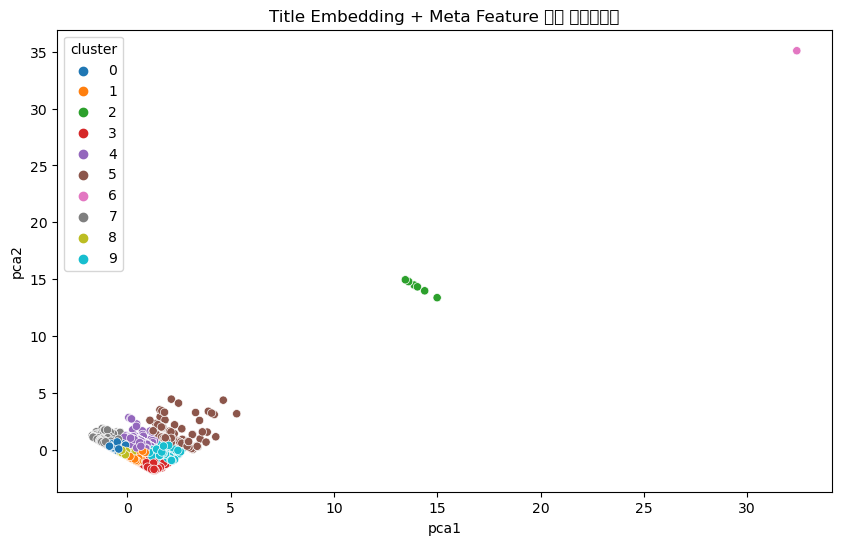

In [191]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 1. title_embedding.csv 로드
embedding_df = pd.read_csv("title_embeddings.csv")

# 🔹 2. 전체 피처가 포함된 메타데이터 df (이미 있다고 가정)
# 예: df = pd.read_csv("full_data.csv")
# df에는 video_id, subscriber_count, title_length가 포함돼 있어야 함

# 🔹 3. 병합
merged_df = pd.merge(embedding_df, title_df[['video_id', 'subscriber_count', 'title_length']], on='video_id', how='inner')

# 🔹 4. 피처 추출
embedding_cols = [col for col in merged_df.columns if col.startswith("emb_")]
X_embedding = merged_df[embedding_cols].values
X_meta = merged_df[['subscriber_count', 'title_length']].fillna(0).values

# 🔹 5. 정규화 + 결합
X_combined = np.hstack([X_meta, X_embedding])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

# 🔹 6. KMeans 클러스터링
k = 10  # 군집 수
kmeans = KMeans(n_clusters=k, random_state=42)
merged_df['cluster'] = kmeans.fit_predict(X_scaled)

# 🔹 7. 시각화 (PCA 2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
merged_df['pca1'] = X_pca[:, 0]
merged_df['pca2'] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='pca1', y='pca2', hue='cluster', palette='tab10')
plt.title("Title Embedding + Meta Feature 기반 클러스터링")
plt.show()

# 🔹 8. 저장
#merged_df.to_csv("merged_clustered_result.csv", index=False)


In [199]:
save_dir = r"C:\web\saved_models"
path = os.path.join(save_dir, f"model_kmeans.pkl")
# KMeans 모델 저장
joblib.dump(kmeans, path)  # 저장 경로와 파일명 설정

['C:\\web\\saved_models\\model_kmeans.pkl']